**<h1><center>Deep Learning Systems (ENGR-E 533) 
<br>Homework 3 , Fall 2021</h1>**

**Name: Anitha Ganapathy** <br>
**Email: aganapa@iu.edu** <br>


___

## Organizing Imports


In [ ]:
!pip install tensorflow_addons

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.layers import Rescaling
from keras.layers import BatchNormalization
from keras.utils import np_utils

from keras.datasets import cifar10
import tensorflow_addons as tfa

import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# for Problem 3
import librosa
import copy
import soundfile as sf
import IPython.display as ipd

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from google.colab import drive

drive.mount('/content/drive')  

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Problem 1: Data Augmentation

### Load CIFAR10 Dataset

In [ ]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

### Data pre-processing

In [ ]:
# Function to scale any image to the pixel values of [-1, 1]

def normalize(arr):
    ''' Function to scale an input array to [-1, 1] '''
    arr_min = arr.min()
    arr_max = arr.max()
    # Check the original min and max values
    print('Min: :', arr_min)
    print('Max: :', arr_max)
    arr_range = arr_max - arr_min
    scaled = np.array((arr-arr_min) / float(arr_range), dtype='f')
    arr_new = -1 + (scaled * 2)
    # Make sure min value is -1 and max value is 1
    print('Min: %.3f, Max: %.3f' % (arr_new.min(), arr_new.max()))
    return arr_new

In [ ]:
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')


# Scaling Train and Test data for Baseline model evaluation

scaled_train_features = normalize(train_features/255)
scaled_test_features = normalize(test_features/255)

# scaled_train_features = train_features/255
# scaled_test_features = test_features/255


print("Scaled _Train_features Shape: ",scaled_train_features.shape)
print(f'Scaled_Train_features Min :  {scaled_train_features.min()} \n Scaled_Train_features Max :{scaled_train_features.max()}')
print("\n")


print("scaled_test_features Shape: ",scaled_test_features.shape)
print(f'Scaled_test_features Min :  {scaled_test_features.min()} \n scaled_test_features Max :{scaled_test_features.max()}')

Min: : 0.0
Max: : 1.0
Min: -1.000, Max: 1.000
Min: : 0.0
Max: : 1.0
Min: -1.000, Max: 1.000
Scaled _Train_features Shape:  (50000, 32, 32, 3)
Scaled_Train_features Min :  -1.0 
 Scaled_Train_features Max :1.0


scaled_test_features Shape:  (10000, 32, 32, 3)
Scaled_test_features Min :  -1.0 
 scaled_test_features Max :1.0


In [ ]:
print('Train min=%.3f, max=%.3f' % (train_features.min(), train_features.max()))
print('Test min=%.3f, max=%.3f' % (test_features.min(), test_features.max()))

Train min=0.000, max=255.000
Test min=0.000, max=255.000


### 5,000 validation data split.

Training and evaluation with the built-in methods.

https://www.tensorflow.org/guide/keras/train_and_evaluate

https://stackoverflow.com/questions/20486700/why-do-we-always-divide-rgb-values-by-255

In [ ]:
train_features.shape

(50000, 32, 32, 3)

In [ ]:
scaled_val_features = scaled_train_features[-5000:]
val_labels = train_labels[-5000:]
scaled_train_features = scaled_train_features[:-5000]
train_labels = train_labels[:-5000]

In [ ]:
scaled_train_features.shape, scaled_val_features.shape, train_labels.shape, val_labels.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (45000, 1), (5000, 1))

**Show Examples from Each Class**  <br>
**Understanding the original labels**
- airplane : 0
- automobile : 1
- bird : 2
- cat : 3
- deer : 4
- dog : 5
- frog : 6
- horse : 7
- ship : 8
- truck : 9

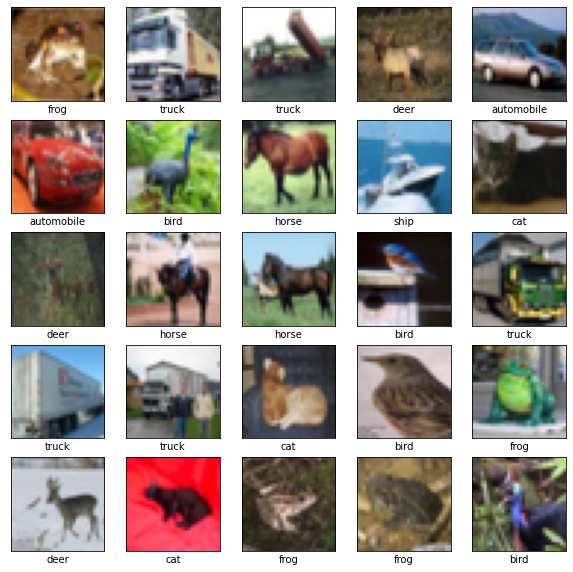

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_features[i]/255.)
    # plt.imshow((scaled_train[i] * 255).astype(np.uint8))
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### User function to plot the model history of accuracy and loss

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Rescaling all the train, validation, test datasets to range [-1, 1]

### Moving the numpy arrays to GPU

In [ ]:
scaled_train_features = tf.convert_to_tensor(scaled_train_features)
scaled_val_features   = tf.convert_to_tensor(scaled_val_features)
scaled_test_features  = tf.convert_to_tensor(scaled_test_features)

print(scaled_train_features.device)
print(scaled_val_features.device)
print(scaled_test_features.device)

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
scaled_train_features.shape

TensorShape([45000, 32, 32, 3])

### Build your baseline CNN classifier.

In [ ]:
# making notes of the changes done to the model
# removed padding = 'same',
# changed the filters from 32 to 10




model = Sequential([
    Conv2D(filters= 10, kernel_size=(5, 5), activation='relu', strides =1, 
            kernel_initializer= 'he_uniform',
           input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=10, kernel_size=(5, 5), activation='relu', strides=1,
           padding = 'same',kernel_initializer= 'he_uniform',),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=20, activation='relu' , kernel_initializer='he_uniform'),
    Dense(units=10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        760       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 10)        2510      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 490)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                9820      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [ ]:
# Compile the model
optimizer_cnn = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_cnn, loss=SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
%%time
# Train the model

batch_size = 512
n_epochs = 300

history = model.fit(x= scaled_train_features, y= train_labels,                   
                    batch_size=batch_size, epochs= n_epochs, 
                    validation_batch_size = batch_size,
                    validation_data = (scaled_val_features, val_labels), 
                    steps_per_epoch = len(scaled_train_features)//batch_size,
                    #  validation_freq = 10,
                    validation_steps = len(scaled_val_features)//batch_size,
                    verbose=2)

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


87/87 - 2s - loss: 2.0140 - accuracy: 0.2634 - val_loss: 1.7519 - val_accuracy: 0.3672
Epoch 2/300
87/87 - 0s - loss: 1.6328 - accuracy: 0.4137 - val_loss: 1.5145 - val_accuracy: 0.4568
Epoch 3/300
87/87 - 0s - loss: 1.4655 - accuracy: 0.4791 - val_loss: 1.4225 - val_accuracy: 0.4883
Epoch 4/300
87/87 - 0s - loss: 1.3728 - accuracy: 0.5130 - val_loss: 1.3422 - val_accuracy: 0.5211
Epoch 5/300
87/87 - 0s - loss: 1.3093 - accuracy: 0.5376 - val_loss: 1.2965 - val_accuracy: 0.5399
Epoch 6/300
87/87 - 0s - loss: 1.2656 - accuracy: 0.5525 - val_loss: 1.2565 - val_accuracy: 0.5545
Epoch 7/300
87/87 - 0s - loss: 1.2234 - accuracy: 0.5661 - val_loss: 1.2069 - val_accuracy: 0.5751
Epoch 8/300
87/87 - 0s - loss: 1.1953 - accuracy: 0.5768 - val_loss: 1.1894 - val_accuracy: 0.5783
Epoch 9/300
87/87 - 0s - loss: 1.1662 - accuracy: 0.5883 - val_loss: 1.1910 - val_accuracy: 0.5792
Epoch 10/300
87/87 - 0s - loss: 1.1499 - accuracy: 0.5932 - val_loss: 1.1612 - val_accuracy: 0.5883
Epoch 11/300
87/87 - 

### Baseline Model Test Accuracy

In [ ]:
_, test_acc = model.evaluate(scaled_test_features, test_labels, verbose=2)
print(" Baseline Model Test Accuracy:   ",test_acc)

313/313 - 0s - loss: 1.1787 - accuracy: 0.6449
 Baseline Model Test Accuracy:    0.6449000239372253


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


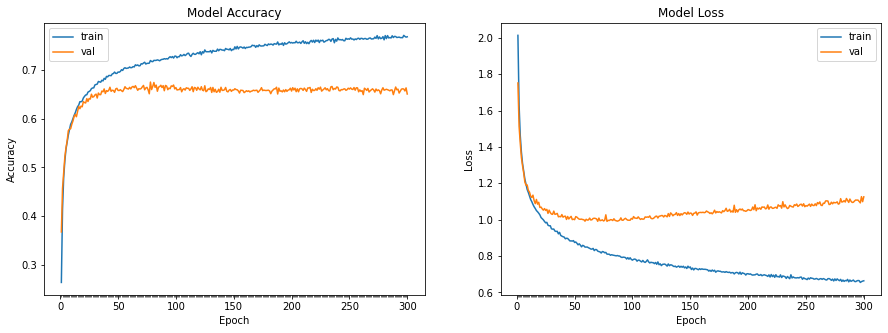

In [ ]:
plot_model_history(history)

### Build another classifier using an augmented dataset.

In [ ]:
model2 = Sequential([
    Conv2D(filters= 10, kernel_size=(5, 5), activation='relu', strides =1, 
            kernel_initializer= 'he_uniform',
           input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=10, kernel_size=(5, 5), activation='relu', strides=1,
           kernel_initializer= 'he_uniform',),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=20, activation='relu', kernel_initializer='he_uniform'),
    Dense(units=10, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 10)        760       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 10)        2510      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5020      
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [ ]:
# Compile the model
optimizer_cnn = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer_cnn, loss=SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [ ]:
train_features = train_features.astype('float32')/255

val_features = train_features[-5000:]
val_labels = train_labels[-5000:]
train_features = train_features[:-5000]
train_labels = train_labels[:-5000]

In [ ]:
def plot_dataset(data, title):
  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

  plt.figure(figsize=(10,10))
  for i in range(10):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.suptitle(title)
      plt.grid(False)
      plt.imshow(data[i])
      # The CIFAR labels happen to be arrays, 
      # which is why you need the extra index
      plt.xlabel(class_names[train_labels[i][0]])
  plt.show()


**Augmentation dataset details**

- Augmented dataset #1: Brighten every pixel in every image by 10%, e.g., by multiplying 1.1. Make sure though, that they don't exceed 1. For example, you may want to do something like this: np.minimum(1.1*X, 1).
- Augmented dataset #2: Darken every pixel in every image by 10%, e.g., by multiplying 0.9.
- Augmented dataset #3: Flip all images horizontally (not upside down, but in the left-right direction). As if they are mirrored.
- Augmented dataset #4: The original training set.

In [ ]:
aug_dataset1 = np.minimum(np.multiply(1.1 , train_features), 1)
aug_dataset2 = 0.9 * train_features
# aug_dataset3 = np.fliplr(train_features)

# aug_dataset3 = np.fliplr(np.reshape(train_features, (-1, 32, 32 , 3)))
# aug_dataset4 = np.flipud(np.reshape(train_features, (-1, 32, 32 , 3)))

In [ ]:
# try using tf.image.flip_left_right(image)
# https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right
# https://www.tensorflow.org/api_docs/python/tf/image

print(train_features.shape)
aug_dataset3 =[]
count = 0
for img in train_features:
  # print(img.shape)
  # imgplot = plt.imshow(img)
  # plt.show()
  img =  np.fliplr(img)
  aug_dataset3.append(img)
  count+=1

aug_dataset3 =np.reshape(aug_dataset3, (-1, 32, 32 , 3))
count, aug_dataset3.shape


(45000, 32, 32, 3)


(45000, (45000, 32, 32, 3))

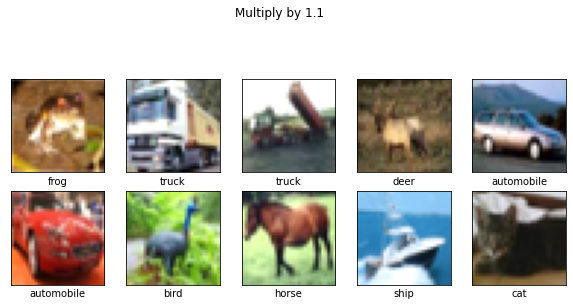

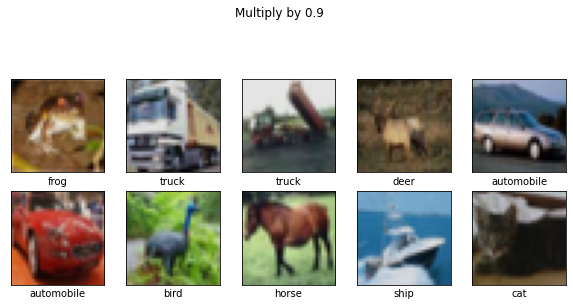

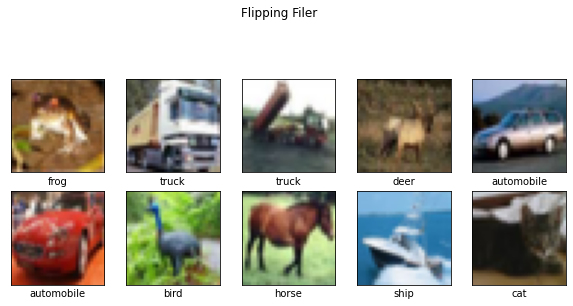

In [ ]:
plot_dataset(aug_dataset1, "Multiply by 1.1")
plot_dataset(aug_dataset2, "Multiply by 0.9")
plot_dataset(aug_dataset3, "Flipping Filer")
# plot_dataset(aug_dataset4, "Horizontal flip")

In [ ]:
total_train_dataset = np.vstack((train_features, aug_dataset1, aug_dataset2, aug_dataset3))
total_train_labels = np.vstack((train_labels, train_labels, train_labels, train_labels))

In [ ]:
total_train_dataset.shape, total_train_labels.shape

((180000, 32, 32, 3), (180000, 1))

In [ ]:
# Normalizing and moving the numpy array to tensor GPY 


scaled_tot_train_features = normalize(total_train_dataset)
scaled_val_features_2   = normalize(val_features)


# scaled_tot_train_features = total_train_dataset
# scaled_val_features_2   = val_features


scaled_tot_train_features = tf.convert_to_tensor(scaled_tot_train_features)
scaled_val_features_2   = tf.convert_to_tensor(scaled_val_features_2)

print(scaled_tot_train_features.device)
print(scaled_val_features_2.device)

Min: : 0.0
Max: : 1.0
Min: -1.000, Max: 1.000
Min: : 0.0
Max: : 1.0
Min: -1.000, Max: 1.000
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
%%time
# Train the model

batch_size = 512
n_epochs = 300

history2 = model2.fit(x=scaled_tot_train_features, y = total_train_labels, 
                       batch_size=batch_size, epochs= n_epochs, 
                       validation_batch_size = batch_size,
                       validation_data = (scaled_val_features_2, val_labels), 
                       steps_per_epoch = len(scaled_tot_train_features)//batch_size,
                       validation_steps = len(scaled_val_features_2)//batch_size,
                        verbose=2)

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


351/351 - 2s - loss: 1.8162 - accuracy: 0.3374 - val_loss: 1.5011 - val_accuracy: 0.4510
Epoch 2/300
351/351 - 2s - loss: 1.4220 - accuracy: 0.4876 - val_loss: 1.3580 - val_accuracy: 0.5104
Epoch 3/300
351/351 - 2s - loss: 1.3076 - accuracy: 0.5328 - val_loss: 1.2662 - val_accuracy: 0.5530
Epoch 4/300
351/351 - 2s - loss: 1.2382 - accuracy: 0.5608 - val_loss: 1.2043 - val_accuracy: 0.5720
Epoch 5/300
351/351 - 2s - loss: 1.1844 - accuracy: 0.5818 - val_loss: 1.1610 - val_accuracy: 0.5918
Epoch 6/300
351/351 - 2s - loss: 1.1399 - accuracy: 0.5983 - val_loss: 1.1168 - val_accuracy: 0.6131
Epoch 7/300
351/351 - 2s - loss: 1.1079 - accuracy: 0.6101 - val_loss: 1.0876 - val_accuracy: 0.6204
Epoch 8/300
351/351 - 2s - loss: 1.0834 - accuracy: 0.6200 - val_loss: 1.0645 - val_accuracy: 0.6285
Epoch 9/300
351/351 - 2s - loss: 1.0626 - accuracy: 0.6267 - val_loss: 1.0491 - val_accuracy: 0.6350
Epoch 10/300
351/351 - 2s - loss: 1.0463 - accuracy: 0.6323 - val_loss: 1.0640 - val_accuracy: 0.6345
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


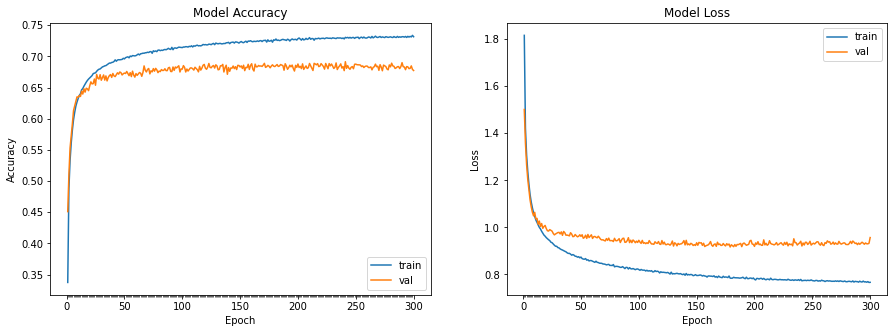

In [ ]:
plot_model_history(history2)

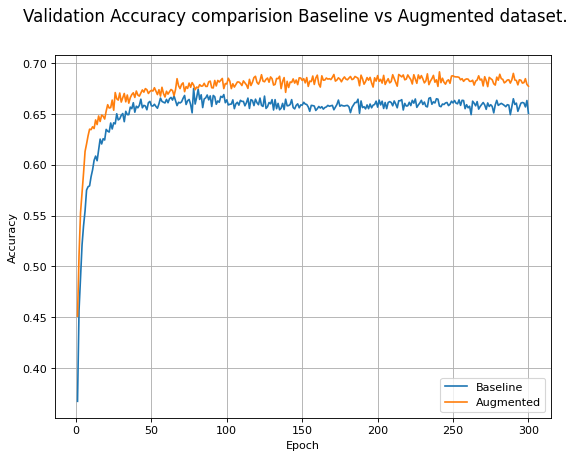

In [ ]:
# fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.figure(figsize=(8, 6), dpi=80)


# summarize history for validation accuracy for baseline and augumented dataset.
plt.plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
plt.plot(range(1,len(history2.history['val_accuracy'])+1),history2.history['val_accuracy'])
plt.suptitle('Validation Accuracy comparision Baseline vs Augmented dataset.', fontsize = 15)
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
plt.legend(['Baseline', 'Augmented'], loc='best')
plt.show()

### Augmented Model Test Accuracy

In [ ]:
_, test_acc = model2.evaluate(scaled_test_features, test_labels, verbose=2)
# print(" Augmented Model Test Accuracy:   ",test_acc)

313/313 - 0s - loss: 0.9880 - accuracy: 0.6783


## Problem 2: Self-Supervised Learning via Pretext Tasks

### Load CIFAR10 Dataset

In [ ]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))